# ****Importing all required python libraries****

In [35]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import cv2

import warnings
warnings.filterwarnings('ignore')

In [3]:
import matplotlib.pyplot as plt
import PIL.Image as Image 
from pathlib import Path
from glob import glob
import pandas as pd
import os


In [113]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.layers import Input, Dense, Flatten
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model
from keras.losses import MeanSquaredError
from tensorflow.keras import layers


# **Importing the Pre-trained InceptionV3 CNN model**

In [79]:
IMAGE_SIZE = [224,224] # Resize the size of all images 
Inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)# # add preprocessing layer to the front of Inception

# ****Testing the model without re-training****

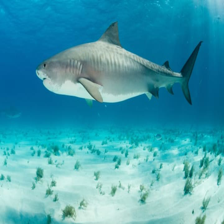

In [80]:
# Reading of a sample image
tiger_shark = Image.open('../input/tiger-shark/tiger_shark.jpg').resize(IMAGE_SIZE)
display (tiger_shark)

In [81]:
# Scaling/Normalising of image 

tiger_shark = np.array(tiger_shark)/255.0
tiger_shark.shape


(224, 224, 3)

In [82]:
tiger_shark[:5]

array([[[0.01176471, 0.50980392, 0.7254902 ],
        [0.01176471, 0.51764706, 0.73333333],
        [0.00784314, 0.53333333, 0.74117647],
        ...,
        [0.56470588, 0.76470588, 0.83137255],
        [0.55294118, 0.75294118, 0.81960784],
        [0.55294118, 0.75294118, 0.81960784]],

       [[0.00784314, 0.50588235, 0.72156863],
        [0.00392157, 0.50980392, 0.7254902 ],
        [0.00392157, 0.52156863, 0.72941176],
        ...,
        [0.55686275, 0.75686275, 0.82352941],
        [0.54509804, 0.74509804, 0.81176471],
        [0.53333333, 0.73333333, 0.8       ]],

       [[0.00784314, 0.50588235, 0.72156863],
        [0.00392157, 0.50588235, 0.72156863],
        [0.        , 0.50980392, 0.72156863],
        ...,
        [0.54117647, 0.75294118, 0.81960784],
        [0.5254902 , 0.7372549 , 0.80392157],
        [0.51764706, 0.7254902 , 0.79607843]],

       ...,

       [[0.50196078, 0.77647059, 0.75294118],
        [0.49019608, 0.76862745, 0.74901961],
        [0.45490196, 0

In [83]:
# Adding a new axis to the image
tiger_shark[np.newaxis, ...].shape

(1, 224, 224, 3)

# ****Result****

In [84]:
result = Inception.predict(tiger_shark[np.newaxis, ...])
result.shape


(1, 5, 5, 2048)

In [44]:
predicted_label_index = np.argmax(result)
predicted_label_index

39271

In [85]:
image_labels = []
with open("../input/imagenetlabels/ImageNetLabels.txt", "r") as img:
    image_labels = img.read().splitlines()
image_labels[:5]

['background', 'tench', 'goldfish', 'great white shark', 'tiger shark']

In [46]:
image_labels[predicted_label_index]

IndexError: list index out of range

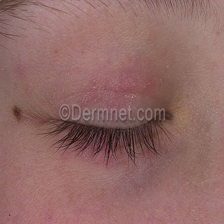

In [88]:
# Reading the image from the custom dataset
PerioralDermEye = Image.open('../input/dermnet/test/Acne and Rosacea Photos/07PerioralDermEye.jpg').resize(IMAGE_SIZE)
PerioralDermEye

In [89]:
PerioralDermEye = np.array(PerioralDermEye)/255.0
PerioralDermEye.shape

(224, 224, 3)

In [91]:
result1 = Inception.predict(PerioralDermEye[np.newaxis, ...])
result1.shape

(1, 5, 5, 2048)

In [24]:
predicted_label_index = np.argmax(result1)
predicted_label_index

839

In [25]:
image_labels[predicted_label_index]

'sunscreen'

In [92]:
# Loading our custom skin disease dataset
train_path = '../input/dermnet/train'
valid_path = '../input/dermnet/test'

# **Process of re-training the model with the dataset**

In [93]:
# Not training the existing weights
for layer in Inception.layers:
  layer.trainable = False

In [ ]:
# Get the list of all classes 
folders = glob('../input/dermnet/train/*')
folders

In [95]:
x = Flatten()(Inception.output)

prediction = Dense(len(folders), activation='softmax')(x)

model = Model(inputs = Inception.input, outputs = prediction)

model.summary()

In [99]:
## Tell the model what cost and otimization method to use
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [100]:
## Data Augmentation

train_datagen = ImageDataGenerator(rescale= 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale= 1./255)


training_set = train_datagen.flow_from_directory('../input/dermnet/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = train_datagen.flow_from_directory('../input/dermnet/test',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

In [ ]:
training_set.class_indices # Labels the list of classes


# **Creating Callback**

In [104]:
filepath = 'my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'

checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint]

# **Fitting the model**

In [106]:
r = model.fit_generator(
    training_set,
    validation_data = test_set,
    epochs = 70,
    steps_per_epoch = len(training_set),
    validation_steps = len(test_set),
    callbacks=callbacks   
)

Epoch 1/70
487/487 [==============================] - 382s 776ms/step - loss: 11.4713 - accuracy: 0.2092 - val_loss: 10.9066 - val_accuracy: 0.2169

Epoch 00001: loss improved from inf to 11.47128, saving model to my_best_model.epoch01-loss10.91.hdf5
Epoch 2/70
487/487 [==============================] - 297s 611ms/step - loss: 11.0737 - accuracy: 0.2846 - val_loss: 12.7089 - val_accuracy: 0.2716

Epoch 00002: loss improved from 11.47128 to 11.07369, saving model to my_best_model.epoch02-loss12.71.hdf5
Epoch 3/70
487/487 [==============================] - 298s 611ms/step - loss: 10.3859 - accuracy: 0.3257 - val_loss: 15.6637 - val_accuracy: 0.2454

Epoch 00003: loss improved from 11.07369 to 10.38594, saving model to my_best_model.epoch03-loss15.66.hdf5
Epoch 4/70
487/487 [==============================] - 297s 611ms/step - loss: 10.2726 - accuracy: 0.3562 - val_loss: 13.8429 - val_accuracy: 0.2981

Epoch 00004: loss improved from 10.38594 to 10.27261, saving model to my_best_model.epoc

In [107]:
model.evaluate(test_set)

126/126 [==============================] - 61s 482ms/step - loss: 27.3876 - accuracy: 0.3661


[27.3875675201416, 0.36606696248054504]

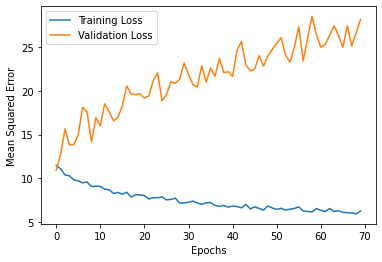

In [111]:
plt.plot(r.history['loss'], label='Training Loss')
plt.plot(r.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.savefig('model_training_history')
plt.show()